참고 (딥러닝을 이용한 자연어 처리)
: https://wikidocs.net/94600

위 링크에는 keras framework로 신경망을 구현한 반면, 이번 과제에서는 **pytorch** framework로 구현해보도록 합니다.

참고 : https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_recurrent_neuralnetwork/
https://wonhwa.tistory.com/35

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cuda is available.


### 데이터 불러오기 (네이버 쇼핑 리뷰 감성 분석 데이터)

In [3]:
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 40.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 9.4 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1232 sha256=4b5172bdaa0137344015d1d8cb7cf92056c10e6bdab5d99fc31322b1916ff440
  Stored in directory: /root/.cache/pip/wheels/ec/41/c8/ce8fb469be2547ce596c4000613806505dc54c296aae45da71
Successfully built mecab-python
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0   805k      0  0:00:01  0:00:01 --:--:--  387M
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example

In [4]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
# 데이터 로드하기
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")
total_data = pd.read_table('ratings_total.txt', names = ['ratings', 'reviews'])

# 데이터 개수 확인
print('리뷰 개수 : ', len(total_data))

리뷰 개수 :  200000


In [6]:
total_data[:5] # 상위 5개 데이터만 샘플로 확인

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [7]:
# 감성 분석을 위한 라벨링
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0) # 4,5점은 긍정 1 / 1,2 점은 부정 0 으로 라벨링
total_data.drop_duplicates(subset=['reviews'], inplace=True) # 중복 제거

# 훈련 데이터와 테스트 데이터 split
train_data, test_data = train_test_split(total_data, test_size = 0.2, random_state = 42)

In [8]:
train_data['label'].value_counts()

label
1    80003
0    79923
Name: count, dtype: int64

### 데이터 정제 및 전처리

In [9]:
# 한글과 공백을 제외하고 모두 제거 (train)
# [^ㄱ-ㅎㅏ-ㅣ가-힣 ]: 정규 표현식으로, 한글(모음과 자음)과 띄어쓰기를 제외한 문자들을 매칭
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)

# test data에도 동일하게 적용
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거

### 토큰화

In [10]:
# Mecab 모델로 형태소 분석 및 토큰화
mecab = Mecab()

# 불용어 설정
# stopword.txt 파일이 저장된 경로를 정확히 입력해주세요
with open('/content/drive/MyDrive/KUBIG/WEEK 1/stopword.txt') as f:
    list_file = f.readlines()

stopwords_list = []
for stopword in list_file:
  stopwords = re.sub('[\n]', '', stopword)
  stopwords_list.append(stopwords)

# train data 토큰화
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list])

# test data 토큰화
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords_list])

In [20]:
print(train_data['reviews'].head())
print(train_data['tokenized'].head())

132466      바디버든 줄이려고 써보려고 샀는데 음용할수잇는 물로 헹궈야되면 왜 식기세척기 쓰나요?
188461    시중에 판매하는 건새우랑 다르게 속살이 고루분포된게아니라 속이비어보이고 속살이 한쪽...
124757                                       깔끔하니 이쁘네요 좋습니다
50357                                  사이즈미스! 남자가 쓰기엔 너무작네요
137655                               좋은 상품 빠르고 안전한 배송 감사합니다
Name: reviews, dtype: object
132466    [바디, 버든, 줄이, 려고, 써, 보, 려고, 샀, 는데, 음용, 할, 수, 잇,...
188461    [시중, 판매, 는, 건, 새, 우랑, 다르, 게, 속살, 고루, 분포, 된, 게,...
124757                                   [깔끔, 니, 이쁘, 네요, 좋]
50357                  [사이즈, 미스, !, 남자, 쓰, 기, 엔, 너무, 작, 네요]
137655                [좋, 은, 상품, 빠르, 고, 안전, 한, 배송, 감사, 합니다]
Name: tokenized, dtype: object


### 정수 인코딩

In [11]:
# train과 test를 위한 X,Y data 분류

X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [12]:
# 단어 집합 생성 및 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [13]:
# vocab_size 설
vocab_size = len(tokenizer.word_index)

# 텍스트 시퀀스 -> 정수 시퀀스
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### 패딩




In [14]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 88
리뷰의 평균 길이 : 17.154027487713066


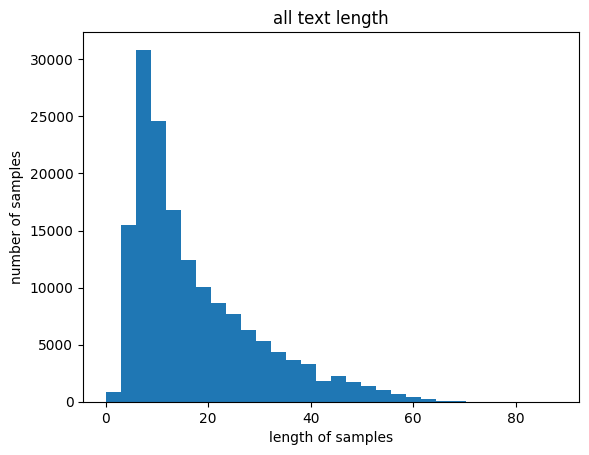

In [15]:
import matplotlib.pyplot as plt

num_tokens = [len(review) for review in X_train]

plt.title('all text length')
plt.hist(num_tokens, bins=30)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
select_length = 40

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1

    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(select_length, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9337005865212661


In [17]:
# 최대 길이를 40으로 잡고 패딩
max_len = 40
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [18]:
# model 변경 함수
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

### DataLoader 생성

In [19]:
from torch.utils.data import Dataset, DataLoader

class LabeledNumpyArrayDataset(Dataset):
    def __init__(self, numpy_data, numpy_labels, transform=None):
        self.data = numpy_data
        self.labels = numpy_labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.labels[index]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [20]:
batch_size = 64

# 레이블링된 데이터셋 객체 생성
train_dataset = LabeledNumpyArrayDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = LabeledNumpyArrayDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### 모델 학습 (Vanilla RNN)

In [21]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(RNNModel, self).__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.rnn = nn.RNN(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)

        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)
        out, h0 = self.rnn(embedded, h0.detach())

        # 현재 out의 차원은 (batch_size, seq_length, hidden_size)입니다.
        # 이를 fully connected layer에 fit하게 차원을 변경(batch_size, hidden_size)해주어야 합니다.
        out = out[:, -1, :] # 64 x 64 size

        """
        문제 1: 이제 out을 우리가 원하는 ouput_dim 차원으로 변환해주어야 합니다.
        빈칸에 들어갈 인스턴스 변수를 채워넣어주세요.
        """
        out = self.fc(out)
        return out

In [22]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = RNNModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)


"""
문제 2: RNN에서 loss를 계산하는 기준은 무엇일까요? 빈칸에 알맞은 답을 적어주세요
"""
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [23]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)



        """
        문제2: loss를 구하기 위해서 위에서 정의한 변수 중 무엇을 사용하면 될까요? 빈칸을 채워넣어주세요.
        """
        loss = criterion(logits, labels)

        loss.backward()

        """
        문제3: 역전파를 거친 후 매개변수(가중치)를 업데이트하기 위해서 필요한 메서드는 무엇이었나요?
        빈칸을 채워넣어주세요.
        """
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))



Iteration: 500. Loss: 0.23244202136993408. Accuracy: 87.16422271728516
Iteration: 1000. Loss: 0.46660730242729187. Accuracy: 87.85953521728516
Iteration: 1500. Loss: 0.40308573842048645. Accuracy: 87.61692810058594
Iteration: 2000. Loss: 0.21677204966545105. Accuracy: 88.49732208251953
Iteration: 2500. Loss: 0.3640497028827667. Accuracy: 76.08673858642578
Iteration: 3000. Loss: 0.260485976934433. Accuracy: 88.42979431152344
Iteration: 3500. Loss: 0.20878805220127106. Accuracy: 87.76699829101562
Iteration: 4000. Loss: 0.3984775245189667. Accuracy: 88.87248992919922
Iteration: 4500. Loss: 0.3465484082698822. Accuracy: 89.02506256103516
Iteration: 5000. Loss: 0.3478025794029236. Accuracy: 87.22174835205078
Iteration: 5500. Loss: 0.2240789234638214. Accuracy: 88.21969604492188
Iteration: 6000. Loss: 0.30551716685295105. Accuracy: 88.29222869873047
Iteration: 6500. Loss: 0.12489945441484451. Accuracy: 88.06462860107422
Iteration: 7000. Loss: 0.16007180511951447. Accuracy: 88.50232696533203


### 모델학습 (LSTM, Long short term memory)

In [43]:
class LSTMModel(nn.Module):

    def __init__(self,vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(LSTMModel, self).__init__()

        self.device = device

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layers
        self.lstm = nn.LSTM(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)

        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # 초기에 cell state를 영행렬로 초기화
        c0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        c0 = c0.to(self.device)

        out, (hn, cn) = self.lstm(embedded, (h0.detach(), c0.detach()))

        # 현재 out의 차원은 (batch_size, seq_length, hidden_size)입니다.
        # 이를 fully connected layer에 fit하게 차원을 변경(batch_size, hidden_size)해주어야 합니다.
        out = out[:, -1, :]

        # fc layer를 통해 (batch_size, output_dim)로 차원을 변경해줍니다.
        out = self.fc(out)

        return out

In [37]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = LSTMModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [38]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)

        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.21996808052062988. Accuracy: 90.96593475341797
Iteration: 2000. Loss: 0.21699008345603943. Accuracy: 91.40863800048828
Iteration: 3000. Loss: 0.17068840563297272. Accuracy: 91.64373779296875
Iteration: 4000. Loss: 0.22258378565311432. Accuracy: 91.67375183105469
Iteration: 5000. Loss: 0.17681097984313965. Accuracy: 91.86133575439453
Iteration: 6000. Loss: 0.16026248037815094. Accuracy: 91.63874053955078
Iteration: 7000. Loss: 0.1275542676448822. Accuracy: 91.72628021240234
Iteration: 8000. Loss: 0.09390347450971603. Accuracy: 91.43364715576172
Iteration: 9000. Loss: 0.07567159831523895. Accuracy: 91.46865844726562
Iteration: 10000. Loss: 0.10750867426395416. Accuracy: 91.66374969482422
Iteration: 11000. Loss: 0.0759863331913948. Accuracy: 91.19853973388672
Iteration: 12000. Loss: 0.1739925891160965. Accuracy: 91.29608154296875
Iteration: 13000. Loss: 0.1147947609424591. Accuracy: 91.3386001586914
Iteration: 14000. Loss: 0.20850196480751038. Accuracy: 91.1510162

### 모델 학습 (Gated Recurrent Unit (GRU))

In [39]:
class GRUModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # GRU layers
        self.gru = nn.GRU(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):

        embedded = self.embedding(text)

        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(embedded, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out


In [40]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

model = GRUModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)

criterion = nn.CrossEntropyLoss()

In [41]:
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        model.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(text).to(device)
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(logits, labels)
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 1000 == 0:
            model.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = model(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 1000. Loss: 0.198025643825531. Accuracy: 90.78335571289062
Iteration: 2000. Loss: 0.14189721643924713. Accuracy: 91.5737075805664
Iteration: 3000. Loss: 0.21184831857681274. Accuracy: 91.61372375488281
Iteration: 4000. Loss: 0.1486952304840088. Accuracy: 91.6062240600586
Iteration: 5000. Loss: 0.2026442289352417. Accuracy: 91.13851165771484
Iteration: 6000. Loss: 0.2651044428348541. Accuracy: 91.39363098144531
Iteration: 7000. Loss: 0.19412539899349213. Accuracy: 91.62373352050781
Iteration: 8000. Loss: 0.07363325357437134. Accuracy: 91.4886703491211
Iteration: 9000. Loss: 0.15135401487350464. Accuracy: 91.26107025146484
Iteration: 10000. Loss: 0.1332351267337799. Accuracy: 91.32609558105469
Iteration: 11000. Loss: 0.15410858392715454. Accuracy: 91.01596069335938
Iteration: 12000. Loss: 0.16534507274627686. Accuracy: 91.3661117553711
Iteration: 13000. Loss: 0.16523891687393188. Accuracy: 91.02596282958984
Iteration: 14000. Loss: 0.2349354475736618. Accuracy: 91.0434722900390

## 모델 성능 비교

옵티마이저, 파라미터 등을 바꿔가며 모델의 성능을 향상시켜보세요.

이후 세 가지 모델의 성능 차이를 비교하고, 자유롭게 해석해보세요!

Vanilla RNN은 (Optimizer:SGD, lr=0.01)일 때 대략 89.38%의 accuarcy으로 가장 높은 성능을 보인다.
LSTM은 (Optimizer:SGD, lr=0.01)일 때 대략 90.07%의 accuarcy으로 가장 높은 성능을 보인다.
GRU은 (Optimizer:Adam, lr=0.005)일 때 대략 89.94%의 accuarcy으로 가장 높은 성능을 보인다.

Vanilla RNN이 LSTM과 GRU에 비해 성능이 약간 낮은 이유는 장기 의존성을 효과적으로 학습하는 능력이 부족하기 때문이다.
LSTM은 특히 복잡한 데이터셋에서 장기 의존성을 처리하는 능력이 뛰어나기에 높은 성능을 보인 것으로 보인다.

### 모델 학습 (Vanilla RNN)

In [38]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

rnnmodel = RNNModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
rnnmodel = rnnmodel.to(device)

criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Vanilla RNN은 (Optimizer:SGD, lr=0.01)일 때 대략 89.38%의 accuarcy, 가장 높은 성능을 보인다.

In [39]:
## Optimizer : Adam, lr=0.005로 했을 때, 86~87%의 정확도를 보임

optimizer = torch.optim.Adam(rnnmodel.parameters(), lr= 0.005)

iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        rnnmodel.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = rnnmodel(text).to(device)

        loss = criterion(logits, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            rnnmodel.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = rnnmodel(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))



Iteration: 500. Loss: 0.4623680114746094. Accuracy: 84.57806396484375
Iteration: 1000. Loss: 0.433148592710495. Accuracy: 88.61737823486328
Iteration: 1500. Loss: 0.402116596698761. Accuracy: 87.17672729492188
Iteration: 2000. Loss: 0.27145978808403015. Accuracy: 88.75743865966797
Iteration: 2500. Loss: 0.19606149196624756. Accuracy: 88.91751098632812
Iteration: 3000. Loss: 0.2097388058900833. Accuracy: 89.24766540527344
Iteration: 3500. Loss: 0.20126725733280182. Accuracy: 89.54779815673828
Iteration: 4000. Loss: 0.38205525279045105. Accuracy: 88.83747863769531
Iteration: 4500. Loss: 0.22762200236320496. Accuracy: 88.88249969482422
Iteration: 5000. Loss: 0.3460439145565033. Accuracy: 88.96253204345703
Iteration: 5500. Loss: 0.3205146789550781. Accuracy: 89.13011169433594
Iteration: 6000. Loss: 0.2840050756931305. Accuracy: 89.1451187133789
Iteration: 6500. Loss: 0.1638791561126709. Accuracy: 89.53279113769531
Iteration: 7000. Loss: 0.18795762956142426. Accuracy: 89.03256225585938
Iter

In [40]:
## Optimizer:SGD, lr=0.01로 했을 때, 89%의 정확도를 보임

optimizer = torch.optim.SGD(rnnmodel.parameters(), lr= 0.01)

iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        rnnmodel.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = rnnmodel(text).to(device)

        loss = criterion(logits, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            rnnmodel.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = rnnmodel(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))



Iteration: 500. Loss: 0.15893375873565674. Accuracy: 88.54985046386719
Iteration: 1000. Loss: 0.23539021611213684. Accuracy: 88.58736419677734
Iteration: 1500. Loss: 0.15383583307266235. Accuracy: 88.742431640625
Iteration: 2000. Loss: 0.2456272542476654. Accuracy: 88.7074203491211
Iteration: 2500. Loss: 0.22789518535137177. Accuracy: 88.88249969482422
Iteration: 3000. Loss: 0.23036862909793854. Accuracy: 88.82747650146484
Iteration: 3500. Loss: 0.3106189966201782. Accuracy: 88.87749481201172
Iteration: 4000. Loss: 0.402420312166214. Accuracy: 88.95252990722656
Iteration: 4500. Loss: 0.15289795398712158. Accuracy: 88.94752502441406
Iteration: 5000. Loss: 0.28344231843948364. Accuracy: 88.95252990722656
Iteration: 5500. Loss: 0.1802365779876709. Accuracy: 88.92752075195312
Iteration: 6000. Loss: 0.31261712312698364. Accuracy: 88.88749694824219
Iteration: 6500. Loss: 0.21175116300582886. Accuracy: 88.84248352050781
Iteration: 7000. Loss: 0.31928372383117676. Accuracy: 88.94752502441406
I

In [41]:
## Optimizer:RMSprop, lr=0.01로 했을 때, 87%의 정확도를 보임

optimizer = torch.optim.RMSprop(rnnmodel.parameters(), lr=0.01)

iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        rnnmodel.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = rnnmodel(text).to(device)

        loss = criterion(logits, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            rnnmodel.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = rnnmodel(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))



Iteration: 500. Loss: 0.3098694682121277. Accuracy: 88.40228271484375
Iteration: 1000. Loss: 0.20782653987407684. Accuracy: 88.76244354248047
Iteration: 1500. Loss: 0.21537156403064728. Accuracy: 88.20719146728516
Iteration: 2000. Loss: 0.2968992590904236. Accuracy: 88.75743865966797
Iteration: 2500. Loss: 0.18234772980213165. Accuracy: 88.4673080444336
Iteration: 3000. Loss: 0.28011950850486755. Accuracy: 86.779052734375
Iteration: 3500. Loss: 0.14468751847743988. Accuracy: 87.8170166015625
Iteration: 4000. Loss: 0.37607240676879883. Accuracy: 87.52438354492188
Iteration: 4500. Loss: 0.253450483083725. Accuracy: 86.56895446777344
Iteration: 5000. Loss: 0.4240882098674774. Accuracy: 83.94527435302734
Iteration: 5500. Loss: 0.3449435830116272. Accuracy: 86.9691390991211
Iteration: 6000. Loss: 0.140494242310524. Accuracy: 87.6644515991211
Iteration: 6500. Loss: 0.41008228063583374. Accuracy: 87.08419036865234
Iteration: 7000. Loss: 0.24357305467128754. Accuracy: 87.69196319580078
Iterati

### 모델학습 (LSTM, Long short term memory)

LSTM은 (Optimizer:SGD, lr=0.01)일 때 대략 90.07%의 accuarcy, 가장 높은 성능을 보인다.

In [44]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

lstm = LSTMModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
lstm = lstm.to(device)

criterion = nn.CrossEntropyLoss()

In [45]:
## Optimizer:Adam, lr=0.005로 했을 때, 89~90%의 정확도를 보임

optimizer = torch.optim.Adam(lstm.parameters(), lr= 0.005)

iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        lstm.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = lstm(text).to(device)

        loss = criterion(logits, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            lstm.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = lstm(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))



Iteration: 500. Loss: 0.26666927337646484. Accuracy: 89.35520935058594
Iteration: 1000. Loss: 0.3108665645122528. Accuracy: 90.17558288574219
Iteration: 1500. Loss: 0.2823532521724701. Accuracy: 90.92842102050781
Iteration: 2000. Loss: 0.20254823565483093. Accuracy: 91.29608154296875
Iteration: 2500. Loss: 0.19240929186344147. Accuracy: 91.69376373291016
Iteration: 3000. Loss: 0.07332904636859894. Accuracy: 91.6112289428711
Iteration: 3500. Loss: 0.24435630440711975. Accuracy: 91.58871459960938
Iteration: 4000. Loss: 0.12502892315387726. Accuracy: 91.6062240600586
Iteration: 4500. Loss: 0.10044752061367035. Accuracy: 91.5286865234375
Iteration: 5000. Loss: 0.1757451295852661. Accuracy: 91.49617767333984
Iteration: 5500. Loss: 0.1470245122909546. Accuracy: 91.57621002197266
Iteration: 6000. Loss: 0.12636300921440125. Accuracy: 91.56370544433594
Iteration: 6500. Loss: 0.117464579641819. Accuracy: 91.63373565673828
Iteration: 7000. Loss: 0.13797461986541748. Accuracy: 91.69376373291016
It

In [47]:
## Optimizer:SGD, lr=0.01로 했을 때, 90%의 정확도를 보임

optimizer = torch.optim.SGD(lstm.parameters(), lr= 0.01)

iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        lstm.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = lstm(text).to(device)

        loss = criterion(logits, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            lstm.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = lstm(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))



Iteration: 500. Loss: 0.20439907908439636. Accuracy: 90.15807342529297
Iteration: 1000. Loss: 0.017467577010393143. Accuracy: 90.17558288574219
Iteration: 1500. Loss: 0.019497860223054886. Accuracy: 90.17558288574219
Iteration: 2000. Loss: 0.09811600297689438. Accuracy: 90.18558502197266
Iteration: 2500. Loss: 0.042348235845565796. Accuracy: 90.17308044433594
Iteration: 3000. Loss: 0.049536094069480896. Accuracy: 90.1830825805664
Iteration: 3500. Loss: 0.024068471044301987. Accuracy: 90.19808959960938
Iteration: 4000. Loss: 0.12529808282852173. Accuracy: 90.20309448242188
Iteration: 4500. Loss: 0.048992693424224854. Accuracy: 90.1830825805664
Iteration: 5000. Loss: 0.017695710062980652. Accuracy: 90.19308471679688
Iteration: 5500. Loss: 0.011835437268018723. Accuracy: 90.20059204101562
Iteration: 6000. Loss: 0.02722907066345215. Accuracy: 90.20059204101562
Iteration: 6500. Loss: 0.08280424773693085. Accuracy: 90.1880874633789
Iteration: 7000. Loss: 0.11828725785017014. Accuracy: 90.183

In [58]:
## Optimizer:RMSprop, lr=0.01로 했을 때, 90%의 정확도를 보임

optimizer = torch.optim.RMSprop(lstm.parameters(), lr=0.01)

iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        lstm.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = lstm(text).to(device)

        loss = criterion(logits, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            lstm.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = lstm(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))



Iteration: 500. Loss: 0.16557440161705017. Accuracy: 89.62283325195312
Iteration: 1000. Loss: 0.10880421102046967. Accuracy: 90.06053161621094
Iteration: 1500. Loss: 0.11489634215831757. Accuracy: 90.11555480957031
Iteration: 2000. Loss: 0.14757241308689117. Accuracy: 90.40318298339844
Iteration: 2500. Loss: 0.16698160767555237. Accuracy: 90.08303833007812
Iteration: 3000. Loss: 0.07677867263555527. Accuracy: 89.96798706054688
Iteration: 3500. Loss: 0.18974944949150085. Accuracy: 89.96798706054688
Iteration: 4000. Loss: 0.10198134928941727. Accuracy: 90.05052185058594
Iteration: 4500. Loss: 0.16845190525054932. Accuracy: 89.93547058105469
Iteration: 5000. Loss: 0.24600951373577118. Accuracy: 89.96548461914062
Iteration: 5500. Loss: 0.1655304729938507. Accuracy: 89.93046569824219
Iteration: 6000. Loss: 0.062479566782712936. Accuracy: 89.90545654296875
Iteration: 6500. Loss: 0.113114133477211. Accuracy: 90.2105941772461
Iteration: 7000. Loss: 0.19154992699623108. Accuracy: 89.94047546386

### 모델 학습 (Gated Recurrent Unit (GRU))

GRU은 (Optimizer:Adam, lr=0.005)일 때 대략 89.94%의 accuarcy, 가장 높은 성능을 보인다.

In [51]:
class GRUModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # GRU layers
        self.gru = nn.GRU(
            embedding_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, text):

        embedded = self.embedding(text)

        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, text.size(0), self.hidden_dim).requires_grad_()
        h0 = h0.to(self.device)

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(embedded, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out


In [52]:
num_epoch = 15
batch_size = 64
embedding_dim = 64
hidden_dim = 64
layer_dim = 1
output_dim = 4

gru = GRUModel(vocab_size, embedding_dim, hidden_dim, layer_dim, output_dim, 0.5, device)
gru = gru.to(device)

criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [57]:
## Optimizer:Adam, lr=0.005로 했을 때, 89~90%의 정확도를 보임

optimizer = torch.optim.Adam(gru.parameters(), lr= 0.005)

iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        gru.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = gru(text).to(device)

        loss = criterion(logits, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            gru.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = gru(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))



Iteration: 500. Loss: 0.15115292370319366. Accuracy: 90.56075286865234
Iteration: 1000. Loss: 0.14317834377288818. Accuracy: 91.16852569580078
Iteration: 1500. Loss: 0.1032794937491417. Accuracy: 91.1410140991211
Iteration: 2000. Loss: 0.04147591441869736. Accuracy: 90.9959487915039
Iteration: 2500. Loss: 0.2893505096435547. Accuracy: 91.10599517822266
Iteration: 3000. Loss: 0.07903537154197693. Accuracy: 90.78085327148438
Iteration: 3500. Loss: 0.11190062016248703. Accuracy: 90.60076904296875
Iteration: 4000. Loss: 0.15597884356975555. Accuracy: 90.9159164428711
Iteration: 4500. Loss: 0.16886912286281586. Accuracy: 90.81586456298828
Iteration: 5000. Loss: 0.1910419911146164. Accuracy: 90.6758041381836
Iteration: 5500. Loss: 0.13028234243392944. Accuracy: 90.65079498291016
Iteration: 6000. Loss: 0.09538323432207108. Accuracy: 90.603271484375
Iteration: 6500. Loss: 0.10034126788377762. Accuracy: 90.72332763671875
Iteration: 7000. Loss: 0.10614832490682602. Accuracy: 90.5982666015625
Ite

In [59]:
## Optimizer:SGD, lr=0.01로 했을 때, 89%의 정확도를 보임

optimizer = torch.optim.SGD(gru.parameters(), lr= 0.01)

iter = 0

for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        gru.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = gru(text).to(device)

        loss = criterion(logits, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            gru.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = gru(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))



Iteration: 500. Loss: 0.17024612426757812. Accuracy: 89.9129638671875
Iteration: 1000. Loss: 0.13094373047351837. Accuracy: 89.94047546386719
Iteration: 1500. Loss: 0.13414257764816284. Accuracy: 89.907958984375
Iteration: 2000. Loss: 0.1459893435239792. Accuracy: 89.86544036865234
Iteration: 2500. Loss: 0.14977829158306122. Accuracy: 89.84542846679688
Iteration: 3000. Loss: 0.1515415608882904. Accuracy: 89.85293579101562
Iteration: 3500. Loss: 0.06199626252055168. Accuracy: 89.89295196533203
Iteration: 4000. Loss: 0.08111368119716644. Accuracy: 89.85543823242188
Iteration: 4500. Loss: 0.145072802901268. Accuracy: 89.8404312133789
Iteration: 5000. Loss: 0.07755984365940094. Accuracy: 89.89795684814453
Iteration: 5500. Loss: 0.08293712884187698. Accuracy: 89.8404312133789
Iteration: 6000. Loss: 0.06757053732872009. Accuracy: 89.87294006347656
Iteration: 6500. Loss: 0.0960988998413086. Accuracy: 89.77539825439453
Iteration: 7000. Loss: 0.11012422293424606. Accuracy: 89.84293365478516
Ite

In [60]:
## Optimizer:RMSprop, lr=0.01로 했을 때, 87%의 정확도를 보임

optimizer = torch.optim.RMSprop(gru.parameters(), lr=0.01)
iter = 0
for epoch in range(num_epoch):
    for i, (text, labels) in enumerate(train_dataloader):
        gru.train()

        text = text.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = gru(text).to(device)

        loss = criterion(logits, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            gru.eval()
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for test_text, test_labels in test_dataloader:
                test_text = test_text.to(device)
                test_labels = test_labels.to(device)
                # Forward pass only to get logits/output
                outputs = gru(test_text)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += test_labels.size(0)

                # Total correct predictions
                correct += (predicted == test_labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))



Iteration: 500. Loss: 0.13065630197525024. Accuracy: 89.22765350341797
Iteration: 1000. Loss: 0.15925975143909454. Accuracy: 89.33270263671875
Iteration: 1500. Loss: 0.045990001410245895. Accuracy: 89.77790069580078
Iteration: 2000. Loss: 0.14659105241298676. Accuracy: 89.23265838623047
Iteration: 2500. Loss: 0.27960383892059326. Accuracy: 89.55280303955078
Iteration: 3000. Loss: 0.21135810017585754. Accuracy: 89.30519104003906
Iteration: 3500. Loss: 0.0962991714477539. Accuracy: 89.907958984375
Iteration: 4000. Loss: 0.13293856382369995. Accuracy: 89.77040100097656
Iteration: 4500. Loss: 0.16067011654376984. Accuracy: 89.39522552490234
Iteration: 5000. Loss: 0.18065977096557617. Accuracy: 89.47776794433594
Iteration: 5500. Loss: 0.2817159593105316. Accuracy: 89.31519317626953
Iteration: 6000. Loss: 0.19005942344665527. Accuracy: 89.2176513671875
Iteration: 6500. Loss: 0.17469343543052673. Accuracy: 89.43524932861328
Iteration: 7000. Loss: 0.24737448990345. Accuracy: 88.90000915527344
